In [39]:
# Checking Python's version
!python -V

Python 3.9.16


In [40]:
# Importing libraries

import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import (auc,
                             confusion_matrix,
                             classification_report, 
                             precision_recall_curve)

In [41]:
# Read training and validation data
df_train = pd.read_csv('./data/training_data.csv')
df_val = pd.read_csv('./data/validation_data.csv')

In [46]:
# Creating target variable 
y_train = df_train['Response']
y_val = df_val['Response']

In [65]:
# Create the necessary variables
dependants = ['Kidhome', 'Teenhome']

# assuming analysis was conducted in 2014 
now = 2014

# Define the bin edges
bins = [18, 28, 38, 48, 58, 65, np.inf]

# Define the labels for each age group
labels = ['18-27', '28-37', '38-47', '48-57', '58-65', '65+']

# End of financial year
end_fiscal = datetime(2014, 6, 30)

# Redundant features
red_ftrs_1 = ["ID", "Year_Birth", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Age", "Response"]

# List of categorical and numeric features
categ_ftrs_1 = ['Education', 'Marital_Status', 'Kidhome', 'Teenhome', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Age_Group']

num_ftrs_1 = ['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Onboard_Days']

In [66]:
# Function to do data cleaning and feature preprocessing
def scrub_data(df):
    
    # Convert 'Kidhome' and 'Teenhome' to categorical
    # but first fillna with the most frequent value
    df[dependants] = df[dependants].fillna(df[dependants].mode().iloc[0])
    df[dependants] = df[dependants].applymap(lambda x: 1 if x > 0 else 0)
    
    # Conversions into 'datetime' data type
    # but first fillna in both variables
    df['Year_Birth'] = df['Year_Birth'].fillna(int(df['Year_Birth'].median()))
    df['Year_Birth'] = pd.to_datetime(df['Year_Birth'], format='%Y')
    
    df['Dt_Customer'] = df['Dt_Customer'].fillna(df['Dt_Customer'].mode().iloc[0])
    df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
    
    # Calculate age
    df['Age'] = now - df['Year_Birth'].dt.year
    
    # Create age group feature
    df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
    
    # Calculate the number of days since customer enrolled
    df['Onboard_Days'] = (end_fiscal - df['Dt_Customer']).dt.days
    
    # Droping redundant features
    df = df.drop(red_ftrs_1, axis=1)
    
    # handle missing values and scale numeric data
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('normalize', PowerTransformer(method='yeo-johnson')),
    ])
    
    ct = ColumnTransformer([
        ('num_trans', num_transformer, num_ftrs_1),
        ('cat_trans', SimpleImputer(strategy='most_frequent'), categ_ftrs_1)
    ])
        
    df = pd.DataFrame(ct.fit_transform(df), 
                      columns=num_ftrs_1+categ_ftrs_1)
    
    # Ensure that the final df features are in the right data types
    df[categ_ftrs_1] = df[categ_ftrs_1].astype('str')
    df[num_ftrs_1] = df[num_ftrs_1].astype('float')
    
    return df

In [67]:
# Clean and preprocess the data ones
train_data = scrub_data(df_train)
val_data = scrub_data(df_val)

## Training Model

In [70]:
# From DataFrame to dictionary
train_dicts= train_data.to_dict(orient='records')
val_dicts = val_data.to_dict(orient='records')

In [71]:
# Use dictionary vectorizer
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [72]:
# Define a function that outputs relevant metrics

def metrics_output(X_1, X_2, y_1, y_2, clf):
    """Generate relevant classification metrics

    Args:
        X_1: X_train
        X_2: X_val or X_train if testing model performance on training data
        y_1: y_train
        y_2: y_val or y_train if testing model performance on training data
        clf: classifier
    """
    
    # Fit classifier
    clf.fit(X_1, y_1)
    
    # Get prediction
    y_pred_class = clf.predict(X_2)
    
    # Create confusion matrix table
    cols = pd.MultiIndex.from_tuples(
        [('predictions', 0), ('predictions', 1)]
    )
    indx = pd.MultiIndex.from_tuples(
        [('actual', 0), ('actual', 1)]
    )
    cmat = confusion_matrix(y_2, y_pred_class)
    display(pd.DataFrame(cmat, columns=cols, index=indx))
    
    print('-'*50, '\n')

    # Print classification report
    print(classification_report(y_2, y_pred_class))
    
    print('-'*50)

In [73]:
lr = LogisticRegression(max_iter=300, class_weight='balanced')
metrics_output(X_train, X_val, y_train, y_val, lr)

predictions     
                   0    1
actual 0         386  123
       1           1   47

-------------------------------------------------- 

              precision    recall  f1-score   support

           0       1.00      0.76      0.86       509
           1       0.28      0.98      0.43        48

    accuracy                           0.78       557
   macro avg       0.64      0.87      0.65       557
weighted avg       0.94      0.78      0.82       557

--------------------------------------------------


In [74]:
svc = SVC(random_state=2, probability=True, class_weight='balanced')
metrics_output(X_train, X_val, y_train, y_val, svc)

predictions    
                   0   1
actual 0         413  96
       1           1  47

-------------------------------------------------- 

              precision    recall  f1-score   support

           0       1.00      0.81      0.89       509
           1       0.33      0.98      0.49        48

    accuracy                           0.83       557
   macro avg       0.66      0.90      0.69       557
weighted avg       0.94      0.83      0.86       557

--------------------------------------------------


In [75]:
rfc = RandomForestClassifier(random_state=2, class_weight='balanced')
metrics_output(X_train, X_val, y_train, y_val, rfc)

predictions    
                   0   1
actual 0         482  27
       1          27  21

-------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       509
           1       0.44      0.44      0.44        48

    accuracy                           0.90       557
   macro avg       0.69      0.69      0.69       557
weighted avg       0.90      0.90      0.90       557

--------------------------------------------------


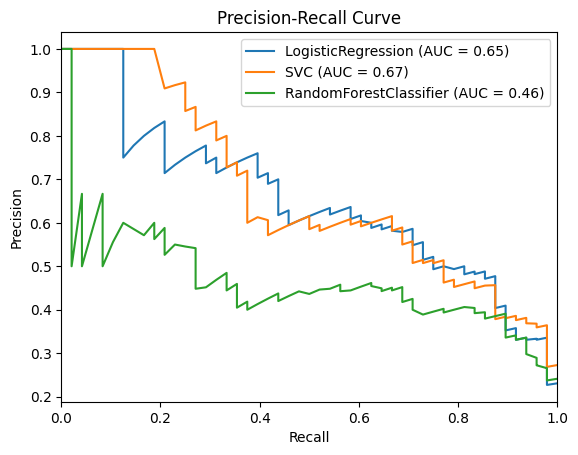

In [76]:
models = [lr, svc, rfc]
 
# Train the models and calculate precision-recall values

results = []
for model in models:
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_val)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, probs)
    results.append((model.__class__.__name__, precision, recall))

# Create a single plot for Precision-Recall curves
fig, ax = plt.subplots()
for name, precision, recall in results:
    auc_score = auc(recall, precision)
    ax.plot(recall, precision, label=f"{name} (AUC = {auc_score:.2f})")

plt.xlabel('Recall')
plt.xlim(0, 1)
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
